<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# План
# -разметить снимки
# -обучить модель
# -проверить на новом снимке, сделать 224**224

In [2]:
# E:\gnat\1 coords и mm\без мм

In [3]:
# !pip install opencv-python

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Переменные
num_epochs=35
random_state=4

In [5]:
# # обрезка до одинакового размера - target_width, target_height
# from PIL import Image
# import os

# # Путь к директории с фотографиями
# foto_directory = r"E:\gnat\3"

# # Целевое разрешение
# target_width, target_height = 690, 690

# # Перебор всех файлов в директории
# for filename in os.listdir(foto_directory):
#     if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Проверка, что файл является изображением
#         img_path = os.path.join(foto_directory, filename)
#         with Image.open(img_path) as img:
#             # Проверка, нужно ли изменять размер изображения
#             if img.size != (target_width, target_height):
#                 # Обрезка изображения
#                 img_resized = img.resize((target_width, target_height))
#                 # Сохранение обрезанного изображения, заменяя оригинал
# #                 img_resized.save(img_path.replace(".jpg", "_resized.jpg"))
#                 img_resized.save(img_path)

In [6]:
from PIL import Image
import os

# Путь к директории с фотографиями
foto_directory = r"E:\gnat\3"

# Целевое разрешение
target_width, target_height = 690, 690

# Перебор всех файлов в директории
for filename in os.listdir(foto_directory):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Проверка, что файл является изображением
        img_path = os.path.join(foto_directory, filename)
        with Image.open(img_path) as img:
            # Проверка, нужно ли обрезать изображение
            if img.size[0] > target_width or img.size[1] > target_height:
                # Вычисление ширины для обрезки
                total_crop_width = img.size[0] - target_width

                # 70% от ширины обрезки слева, 30% - справа
                left_crop = total_crop_width * 0.75
                right_crop = total_crop_width * 0.25

                # Вычисление координат для обрезки
                left = left_crop
                top = 0
                right = img.size[0] - right_crop
                bottom = target_height

                # Убедитесь, что нижняя граница не выходит за пределы изображения
                if bottom > img.size[1]:
                    bottom = img.size[1]

                # Обрезка изображения
                img_cropped = img.crop((left, top, right, bottom))
                # Сохранение обрезанного изображения, заменяя оригинал
                img_cropped.save(img_path)


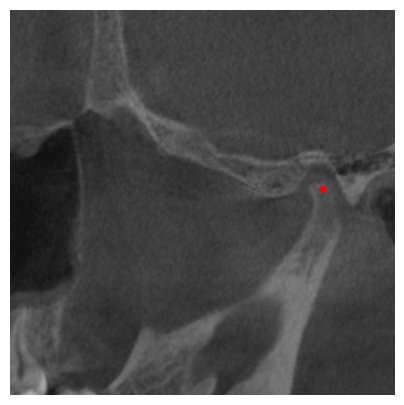

In [7]:
# Загрузим, выведем фото с нашей разметкой

# Путь к директории с фотографиями и CSV-файлом
foto_directory = r"E:\gnat\3"

# Чтение CSV файла
csv_file = os.path.join(foto_directory, "coords3.csv")  # Замените на имя вашего CSV файла
df = pd.read_csv(csv_file)

# Извлечение координат из JSON и создание столбцов x и y
df['x'] = df['region_shape_attributes'].apply(lambda s: json.loads(s).get('cx'))
df['y'] = df['region_shape_attributes'].apply(lambda s: json.loads(s).get('cy'))
df

# Группировка точек по имени файла
grouped = df.groupby('filename')

# Функция для отображения одного изображения с точками
def plot_image_with_points(filename, points_df):
    # Загрузка изображения
    img_path = os.path.join(foto_directory, filename)
    img = mpimg.imread(img_path)

    # Установка размера отображаемого изображения
    plt.figure(figsize=(5, 5))  # Увеличиваем размер изображения

    # Отображение изображения
    plt.imshow(img)
    plt.axis('off')  # Выключить оси

    # Нанесение всех точек
    for index, row in points_df.iterrows():
        plt.scatter(row['x'], row['y'], c='red', s=15)  # s - размер точки

    plt.show()

# Выбор одного изображения и его точек для отображения
sample_filename = list(grouped.groups.keys())[0]  # Преобразование в список и выбор первого имени файла
points_df = grouped.get_group(sample_filename)

# Отображение изображения с точками
plot_image_with_points(sample_filename, points_df)

In [8]:
# Определение уникальных фотографий и разделение на выборки
unique_photos = df['filename'].unique()
test_size_ratio = 0.15
test_photo_count = int(len(unique_photos) * test_size_ratio)
train_photos, test_photos = train_test_split(unique_photos, test_size=test_photo_count, random_state=random_state)
train_df = df[df['filename'].isin(train_photos)]
test_df = df[df['filename'].isin(test_photos)]

# Предобработка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
train_df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,x,y
0,К8Пс.jpg,34733,{},1,0,"{""name"":""point"",""cx"":474,""cy"":292}",{},474,292
1,К68Лс.jpg,24331,{},1,0,"{""name"":""point"",""cx"":204,""cy"":354}",{},204,354
2,К88Пс.jpg,27234,{},1,0,"{""name"":""point"",""cx"":517,""cy"":447}",{},517,447
3,К94Пс.jpg,26474,{},1,0,"{""name"":""point"",""cx"":504,""cy"":334}",{},504,334
5,К111Пс.jpg,20058,{},1,0,"{""name"":""point"",""cx"":557,""cy"":409}",{},557,409
6,К113Пс.jpg,26674,{},1,0,"{""name"":""point"",""cx"":236,""cy"":386}",{},236,386


In [10]:
test_df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes,x,y
4,К104Пс.jpg,30476,{},1,0,"{""name"":""point"",""cx"":558,""cy"":321}",{},558,321


In [11]:
# sdfsdf

In [12]:
# # Загрузка данных
# class PointsDataset(Dataset):
#     def __init__(self, dataframe, image_dir, transform=None):
#         self.dataframe = dataframe
#         self.image_dir = image_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe['filename'].unique())

#     def __getitem__(self, idx):
#         filename = self.dataframe['filename'].unique()[idx]
#         image = Image.open(os.path.join(self.image_dir, filename)).convert('RGB')
#         points = self.dataframe[self.dataframe['filename'] == filename][['x', 'y']].values.flatten()
#         if self.transform:
#             image = self.transform(image)
#         return image, torch.tensor(points, dtype=torch.float32)

# # Создание экземпляров датасета
# train_dataset = PointsDataset(train_df, foto_directory, transform)
# test_dataset = PointsDataset(test_df, foto_directory, transform)
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# # Создание модели
# class RegressionModel(nn.Module):
#     def __init__(self):
#         super(RegressionModel, self).__init__()
#         # Использование ResNet50 как основы
#         self.base_model = resnet50(pretrained=True)
#         # Замена последнего слоя на новый для регрессии координат
#         self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)
#     def forward(self, x):
#         return self.base_model(x)

# # Инициализация
# model = RegressionModel()

# # Определение функции потерь и оптимизатора
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        

# # Функция обучения
# def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
#     model.train()
#     best_loss = float('inf')
#     best_model_wts = None
#     epoch_losses = []  # Список для сохранения потерь каждой эпохи

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         for images, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         epoch_loss = running_loss / len(train_loader)
#         epoch_losses.append(epoch_loss)  # Добавление потерь текущей эпохи в список

#         # Обновление информации о текущей эпохе
#         print(f'\rEpoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}', end='') # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

#         # Сохранение лучшей модели
#         if epoch_loss < best_loss:
#             best_loss = epoch_loss
#             best_model_wts = model.state_dict()

#     # Восстановление лучшей модели
#     model.load_state_dict(best_model_wts)

#     # Построение графика потерь
#     plt.plot(epoch_losses, label='Training Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training Loss per Epoch')
#     plt.legend()
#     plt.show()

#     return model

# trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# # Тестирование
# def test_model(model, test_loader, image_dir):
#     model.eval()
#     with torch.no_grad():
#         for images, labels in test_loader:
#             outputs = model(images).cpu().numpy()  # Получение прогнозов и перевод в numpy массив
#             images = images.cpu().numpy()

#             # Преобразование изображений из тензоров обратно в PIL изображения для отображения
#             images = images.transpose((0, 2, 3, 1))  # Перестановка осей из (N,C,H,W) в (N,H,W,C)
#             images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Денормализация
#             images = np.clip(images, 0, 1)  # Ограничение значений для корректного отображения

#             # Отображение изображений и нанесение точек
#             for i in range(len(images)):
#                 plt.imshow(images[i]) 
#                 plt.scatter(outputs[i][::2], outputs[i][1::2], s=50, marker='.', c=(1, 1, 0))  #  c='y'
#                 plt.axis('off')
#                 plt.show()

# # Тест и вывод изображений с предсказанными точками
# test_model(trained_model, test_loader, foto_directory)

In [ ]:
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

class PointsDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataframe['filename'].unique())

    def __getitem__(self, idx):
        filename = self.dataframe['filename'].unique()[idx]
        image = Image.open(os.path.join(self.image_dir, filename)).convert('RGB')

        # Получение исходных размеров изображения
        original_width, original_height = image.size

        # Получение координат точек
        points = self.dataframe[self.dataframe['filename'] == filename][['x', 'y']].values.flatten()

        # Масштабирование координат точек
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        scaled_points = [points[0] * scale_x, points[1] * scale_y]

        # Применение трансформаций к изображению
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(scaled_points, dtype=torch.float32)

# Создание экземпляров датасета
train_dataset = PointsDataset(train_df, foto_directory, transform)
test_dataset = PointsDataset(test_df, foto_directory, transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Уменьшение размера партии с 4 до 2
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


# Создание модели
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        # Использование ResNet50 как основы
        self.base_model = resnet50(weights=ResNet50_Weights.DEFAULT) # resnet50(pretrained=True)  The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
        # Замена последнего слоя на новый для регрессии координат
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 2)
    def forward(self, x):
        return self.base_model(x)

# Инициализация
model = RegressionModel()

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        

# Функция обучения
def train_model(model, train_loader, criterion, optimizer, num_epochs=1):
    model.train()
    best_loss = float('inf')
    best_model_wts = None
    epoch_losses = []  # Список для сохранения потерь каждой эпохи

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):  # Использование enumerate для отслеживания индекса i
            print(f"Processing batch {i+1}/{len(train_loader)}")  # Вывод информации о текущей партии

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)  # Добавление потерь текущей эпохи в список

        # Обновление информации о текущей эпохе
        print(f'\rEpoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}', end='') 

        # Сохранение лучшей модели
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict()

    # Восстановление лучшей модели
    model.load_state_dict(best_model_wts)

    # Построение графика потерь
    plt.plot(epoch_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.show()

    return model

trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# # Тестирование
# def test_model(model, test_loader, image_dir):
#     model.eval()
#     with torch.no_grad():
#         for images, labels in test_loader:
#             outputs = model(images).cpu().numpy()  # Получение прогнозов и перевод в numpy массив
#             images = images.cpu().numpy()

#             # Преобразование изображений из тензоров обратно в PIL изображения для отображения
#             images = images.transpose((0, 2, 3, 1))  # Перестановка осей из (N,C,H,W) в (N,H,W,C)
#             images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Денормализация
#             images = np.clip(images, 0, 1)  # Ограничение значений для корректного отображения

#             # Отображение изображений и нанесение точек
#             for i in range(len(images)):
#                 plt.imshow(images[i]) 
#                 plt.scatter(outputs[i][::2], outputs[i][1::2], s=50, marker='.', c=(1, 1, 0))  #  c='y'
#                 plt.axis('off')
#                 plt.show()

# # Тест и вывод изображений с предсказанными точками
# test_model(trained_model, test_loader, foto_directory)


import numpy as np
import matplotlib.pyplot as plt

# Тестирование
def test_model(model, test_loader, image_dir, original_sizes):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images).cpu().numpy()  # Получение прогнозов и перевод в numpy массив
            images = images.cpu().numpy()

            # Преобразование изображений из тензоров обратно в PIL изображения для отображения
            images = images.transpose((0, 2, 3, 1))  # Перестановка осей из (N,C,H,W) в (N,H,W,C)
            images = images * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Денормализация
            images = np.clip(images, 0, 1)  # Ограничение значений для корректного отображения

            # Отображение изображений и нанесение точек
            for i in range(len(images)):
                plt.imshow(images[i]) 

                # Обратное масштабирование координат
                original_width, original_height = original_sizes[i]
                unscaled_x = outputs[i][0] * original_width / 224
                unscaled_y = outputs[i][1] * original_height / 224

                plt.scatter(unscaled_x, unscaled_y, s=50, marker='.', c='y')
                plt.title(f'Original Size: {original_width}x{original_height}, Point: ({unscaled_x:.2f}, {unscaled_y:.2f})')
                plt.axis('off')
                plt.show()

# Получение исходных размеров изображений в тестовом наборе данных
original_sizes = []
for filename in test_df['filename'].unique():
    image = Image.open(os.path.join(foto_directory, filename))
    original_sizes.append(image.size)

# Тест и вывод изображений с предсказанными точками
test_model(trained_model, test_loader, foto_directory, original_sizes)

Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [1/35], Loss: 17365.2839Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [2/35], Loss: 16577.6263Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [3/35], Loss: 14843.9746Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [4/35], Loss: 13069.8226Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [5/35], Loss: 10267.7731Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [6/35], Loss: 8667.9821Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [7/35], Loss: 7362.8353Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [8/35], Loss: 5091.3105Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [9/35], Loss: 3955.0391Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [10/35], Loss: 2915.8779Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
Epoch [11/3